In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import dump
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

%matplotlib inline

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
%cd /content/drive/MyDrive/Customer_Purchase_Behavior_Prediction/data

/content/drive/MyDrive/Customer_Purchase_Behavior_Prediction/data


In [22]:
df = pd.read_csv("preprocessed_dataset.csv")
df.head(), df.shape

(   CustomerID  Revenue_given  Frequency  Recency  United Kingdom or Not
 0       12346           0.00          2      326                      1
 1       12347        4310.00        182       40                      0
 2       12348        1797.24         31       76                      0
 3       12349        1757.55         73       19                      0
 4       12350         334.40         17      311                      0,
 (4372, 5))

## **We will be creating an ensemble clustering algorithm using 2 individual clustering algorithms. Then with the help of maximum voting, we will decide the final value**
* K-Means
* K-Medoids

### **K-Means Clustring class**  

In [5]:
class KMeans:
  # Initialization and properties
  def __init__(self):
    self.centroids = np.empty(1)

  # Fit method
  def fit(self, data, clusters, epochs = 1, random_seed = 42):
    np.random.seed(random_seed)
    N = len(data)
    centroids = data[np.random.choice(N, clusters, replace=False), :]

    labels = np.empty(N)
    old_labels = np.empty(N)

    while True:
      distances = np.linalg.norm(data[:, None, :] - centroids, axis=2)
      labels = np.argmin(distances, axis=1)
      for j in range(clusters):
            centroids[j] = np.mean(data[labels == j], axis=0)

      if np.all(labels == old_labels):
            break

      old_labels = labels
    self.centroids = centroids
    return labels

  # Predict method
  def predict(self, data):
      distances = np.linalg.norm(data[:, None, :] - self.centroids, axis=2)
      labels = np.argmin(distances, axis=1)
      return labels

### **K-Medoids Clustering class**

In [6]:
class KMedoids:
  # Initialization and properties
  def __init__(self, data, clusters):
    self.medoids = np.empty(1)
    self.data = data
    self.N = len(data)
    self.clusters = clusters

  # Fit
  def fit(self, random_seed = 42):
    np.random.seed(random_seed)
    data = self.data
    N = self.N
    clusters = self.clusters
    medoids_idx = np.random.choice(N, clusters, replace=False)
    medoids = data[medoids_idx].copy()
    distances = np.zeros((N, clusters))

    for i in range(clusters):
        distances[:, i] = np.sum(np.abs(data - medoids[i]), axis=1)

    labels = np.argmin(distances, axis=1)
    old_labels = np.empty(N)
    all_idxs = np.arange(N)

    while True:
      best_swap = (-1, -1, 0)
      best_distances = np.zeros(N)
      for i in range(clusters):
          non_medoids_idx = all_idxs[np.logical_not(np.isin(all_idxs, medoids_idx))]
          for j in non_medoids_idx:
              new_medoid = data[j]
              new_distances = np.sum(np.abs(data - new_medoid), axis=1)
              cost_change = np.sum(new_distances[labels == i]) - np.sum(
                  distances[labels == i, i]
              )
              if cost_change < best_swap[2]:
                  best_swap = (i, j, cost_change)
                  best_distances = new_distances

      if best_swap == (-1, -1, 0):
            break
      i, j, _ = best_swap
      distances[:, i] = best_distances
      medoids[i] = data[j]

      labels = np.argmin(distances, axis=1)

      old_labels = labels
    self.medoids = medoids
    return labels

  # Predict
  def predict(self, data):
      distances = np.zeros((len(data), self.clusters))
      print(f"Kmedoid: {len(distances)}")
      for i in range(self.clusters):
        distances[:, i] = np.sum(np.abs(data - self.medoids[i]), axis=1)
      labels = np.argmin(distances, axis=1)
      return labels

### **Ensemble Clustering Class**

In [7]:
class EnsembleClustering:
  # Initialization
  def __init__(self, data, clusters):
    self.data = data
    self.clusters = clusters
    self.kmeans = None
    self.kmedoids = None

  # Fit method
  def fit(self):
    kmeans = KMeans()
    kmeans_labels = kmeans.fit(self.data, self.clusters)
    self.kmeans = kmeans

    kmedoids = KMedoids(data = self.data, clusters = self.clusters)
    kmedoids_labels = kmedoids.fit()
    self.kmedoids = kmedoids

    labels = self.maximumVoting(kmeans_labels, kmedoids_labels)
    return labels

  # Maximum voting method
  def maximumVoting(self, labels1, labels2):
    labels = np.zeros(len(labels1), dtype=int)
    for i in range(len(labels1)):
      voting = np.zeros(self.clusters, dtype=int)
      voting[labels1[i]] += 1
      voting[labels1[i]] += 1
      labels[i] = voting.argmax()
    return labels

  # Predict method
  def predict(self, data):
    kmeans_labels = self.kmeans.predict(data)
    kmedoids_labels = self.kmedoids.predict(data)
    labels = self.maximumVoting(kmeans_labels, kmedoids_labels)
    return labels

In [111]:
x = df.drop(["CustomerID"], axis=1)
x = x.sample(frac=1, random_state = 42).reset_index(drop=True)

In [56]:
x_train, x_test = train_test_split(x, train_size = 0.8, stratify=df["United Kingdom or Not"])
x_train.shape, x_test.shape

((3504, 4), (876, 4))

In [66]:
x_train.head()

,Revenue_given,Frequency,Recency,United Kingdom or Not
359,289.99,15,27,1
2893,3456.70,412,20,1
2533,3047.63,977,23,1
1845,2575.00,86,90,1
2062,345.30,9,337,1


In [93]:
data = {
    "Revenue_given": [15207],
    "Frequency": [30],
    "Recency": [13],
    "United Kingdom or Not": [0]
}

In [112]:
X = [152, 30, 13, 0]

In [115]:
x.loc[len(x)] = X

In [116]:
x.shape

(4381, 4)

In [109]:
x = pd.concat([x, X])
x.shape

(4384, 5)

In [106]:
x.tail()

,Revenue_given,Frequency,Recency,United Kingdom or Not,0
4379,1776.81,112.0,46.0,1.0,NaN
0,NaN,NaN,NaN,NaN,152.0
1,NaN,NaN,NaN,NaN,30.0
2,NaN,NaN,NaN,NaN,13.0
3,NaN,NaN,NaN,NaN,0.0


In [95]:
pd.DataFrame(data)

,Revenue_given,Frequency,Recency,United Kingdom or Not
0,15207,30,13,0


In [97]:
transform_data(pd.DataFrame(data))

ValueError: n_components=2 must be between 0 and min(n_samples, n_features)=1 with svd_solver='full'

In [96]:
def transform_data(x):
  pca = PCA(n_components = 2)
  features = pca.fit_transform(x)
  return features

In [58]:
train_features = transform_data(x_train)
test_features = transform_data(x_test)

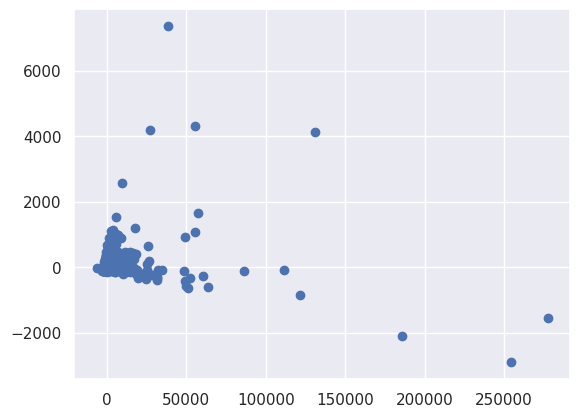

In [49]:
x1 = [train_features[i][0] for i in range(len(train_features))]
x2 = [train_features[i][1] for i in range(len(train_features))]

plt.scatter(x1, x2)
plt.show()

In [14]:
# clusters = [i for i in range(2, 21)]
# scores = []

# for cluster in clusters:
#   e_cluster = EnsembleClustering(data = train_features, clusters = cluster)
#   score = silhouette_score(train_features, e_cluster.fit())
#   scores.append(score)

In [50]:
e_cluster = EnsembleClustering(data = train_features, clusters = 2)
labels = e_cluster.fit()
score = silhouette_score(train_features, e_cluster.fit())
score

0.9854015066646954

In [51]:
len(labels)

4380

In [17]:
e_cluster = EnsembleClustering(data = train_features, clusters = 3)
score = silhouette_score(train_features, e_cluster.fit())
score

0.9496670806578499

In [18]:
e_cluster = EnsembleClustering(data = train_features, clusters = 4)
score = silhouette_score(train_features, e_cluster.fit())
score

0.814514859844423

## **2 Clusters**

In [19]:
# Model initialization
e_cluster = EnsembleClustering(data = train_features, clusters = 2)
# Model training
labels = e_cluster.fit()

### **Model evaluation**

In [20]:
score = silhouette_score(train_features, labels)
score

0.9851758640481331

In [25]:
x_train['cluster'] = labels

In [28]:
show_df_data = {
    "X1": x1,
    "X2": x2,
    "clusters": labels
}
pca_df = pd.DataFrame(show_df_data)
pca_df.head()

,X1,X2,clusters
0,-1537.727640,-77.296694,1
1,-1870.393064,-93.307570,1
2,-1919.403737,-77.384183,1
3,-1775.334097,-56.554134,1
4,-1033.584373,-29.037692,1


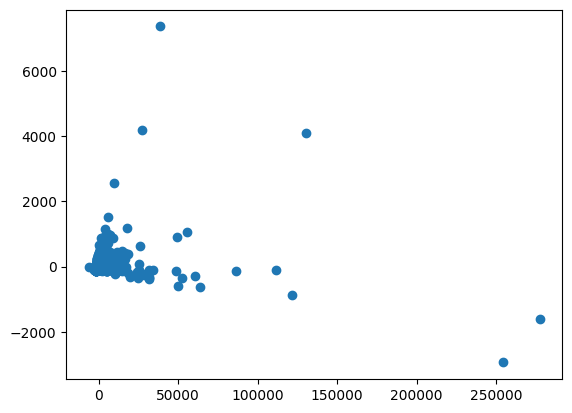

In [30]:
plt.scatter(pca_df["X1"], pca_df["X2"])
plt.show()

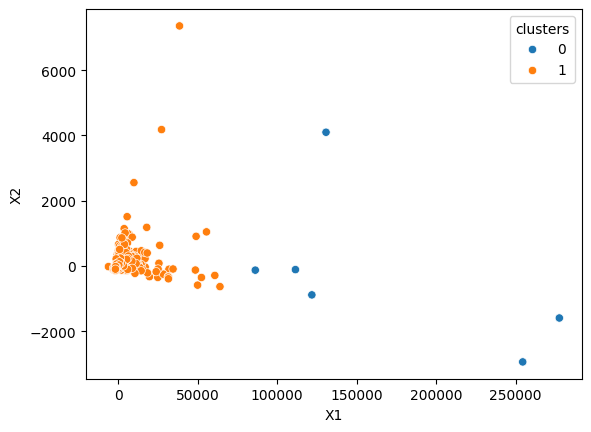

In [33]:
sns.scatterplot(data=pca_df, x="X1", y="X2", hue="clusters")
plt.show()

In [43]:
x_train[x_train['cluster'] == 1].drop(["United Kingdom or Not", "cluster"], axis=1).describe()

,Revenue_given,Frequency,Recency
count,3498.000000,3498.000000,3498.000000
mean,1619.939744,90.286449,101.022584
std,3781.795949,208.553038,113.338820
min,-4287.630000,1.000000,0.000000
25%,293.617500,17.000000,20.000000
50%,646.610000,41.000000,55.000000
75%,1600.640000,101.000000,153.000000
max,65892.080000,7983.000000,697.000000


In [44]:
x_train[x_train['cluster'] == 0].drop(["United Kingdom or Not", "cluster"], axis=1).describe()

,Revenue_given,Frequency,Recency
count,6.000000,6.000000,6.000000
mean,165622.516667,1949.166667,7.500000
std,80988.191296,2018.121841,9.710819
min,88125.380000,433.000000,0.000000
25%,115969.467500,852.500000,0.500000
50%,128149.035000,1248.000000,4.000000
75%,225472.022500,1918.750000,10.500000
max,279489.020000,5903.000000,25.000000


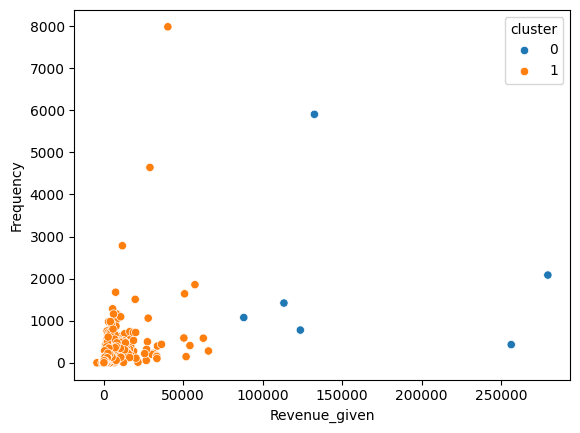

In [36]:
sns.scatterplot(data=x_train, x="Revenue_given", y="Frequency", hue="cluster")
plt.show()

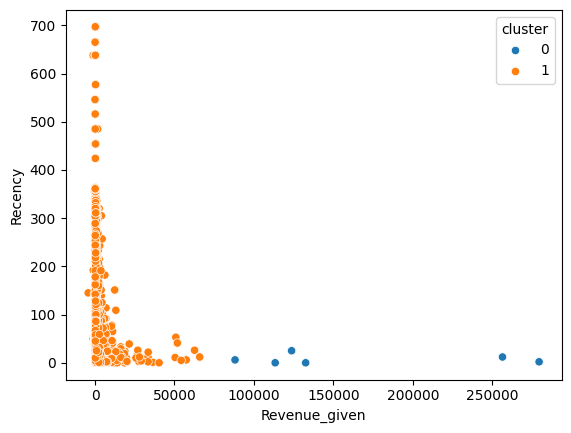

In [37]:
sns.scatterplot(data=x_train, x="Revenue_given", y="Recency", hue="cluster")
plt.show()

In [45]:
sns.set_theme(style='darkgrid')

In [ ]:
import pickle

In [52]:
%cd /content/

/content


In [54]:
from joblib import dump
from joblib import load
dump(e_cluster, "model.joblib")

['model.joblib']

In [55]:
e_cluster = load("model.joblib")

In [59]:
e_cluster.predict(test_features)

876
Kmedoid: 876
876


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

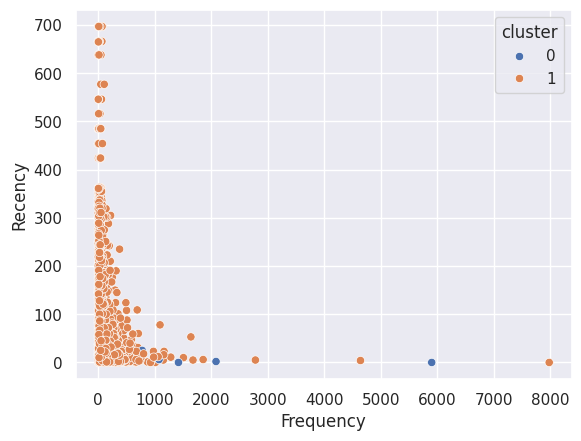

In [46]:
sns.scatterplot(data=x_train, x="Frequency", y="Recency", hue="cluster")
plt.show()

# **Dataset Splitting**
## **We can split our dataset into train and test split. As we are working with the unsupervised dataset, then while evaluating the model performance with the test set, we can't ensure it's clustering accuracy because we don't know the ground truth label or which cluster each sample belongs to. That's why we will be using the whole dataset as the training set and finally, evaluate the model performance using unsupervised performance metrics.**

In [9]:
x_train = df.drop(["CustomerID"], axis=1)
x_train = x_train.sample(frac=1, random_state = 42).reset_index(drop=True)
x_train.shape, x_train.head()

((4372, 4),
    Revenue_given  Frequency  Recency  United Kingdom or Not
 0         893.66         48       35                      1
 1         409.90         27       79                      1
 2         108.07         19      191                      1
 3         509.58         72       19                      1
 4         748.94         43       13                      1)

# **Data Transformation**
## **We will be applying PCA to transform the train set into training features and for dimensionality reduction. We will extract 2 features from 4 individual features.**

In [10]:
def transform_data(data):
  pca = PCA(n_components = 2)
  features = pca.fit_transform(data)
  return features

In [11]:
train_features = transform_data(x_train)

# **Model Evaluation**
## **We wiil be using Silhouette Coefficient as the evaluation metrics.**
* ### **Close to +1 means well-seperated clusters.**
* ### **Close to 0 means overlapping clusters with no clear seperations.**
* ### **Close to -1 means overlapping clusters.**

## **Let's experiment for which number of clusters we get better silhoutte score.**

### **2 Clusters**

#### **Training**

In [25]:
clusters = 2
# Model initialization
e_cluster = EnsembleClustering(data = train_features, clusters = clusters)
# Model training
labels = e_cluster.fit()

#### **Evaluation**

In [13]:
score = silhouette_score(train_features, labels)
f"Silhoutte Score for {clusters} clusters: {score}"

'Silhoutte Score for 2 clusters: 0.9854096307386563'

### **3 Clusters**

#### **Training**

In [14]:
clusters = 3
# Model initialization
e_cluster = EnsembleClustering(data = train_features, clusters = clusters)
# Model training
labels = e_cluster.fit()

#### **Evaluation**

In [15]:
score = silhouette_score(train_features, labels)
f"Silhoutte Score for {clusters} clusters: {score}"

'Silhoutte Score for 3 clusters: 0.9498034331273877'

### **4 Clusters**

#### **Training**

In [16]:
clusters = 4
# Model initialization
e_cluster = EnsembleClustering(data = train_features, clusters = clusters)
# Model training
labels = e_cluster.fit()

#### **Evaluation**

In [17]:
score = silhouette_score(train_features, labels)
f"Silhoutte Score for {clusters} clusters: {score}"

'Silhoutte Score for 4 clusters: 0.8169252284201951'

## **As we increase the number of clusters, our silhoutte coefficient gets far from +1. So, we will proceed with 2 clusters, as it gives the highest silhoutte sccore.**

# **Saving model**

In [23]:
%cd /content/drive/MyDrive/Customer_Purchase_Behavior_Prediction/model

/content/drive/MyDrive/Customer_Purchase_Behavior_Prediction/model


In [24]:
dump(e_cluster, "clustering.joblib")

['clustering.joblib']

# **Post Clustering Analysis**

## **PCA Extracted Features Relationship**

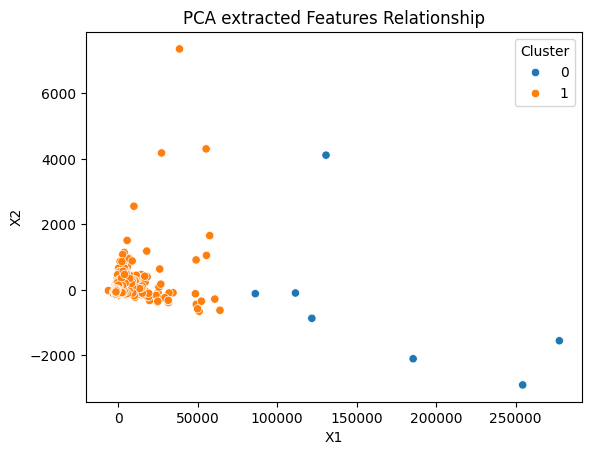

In [40]:
x1 = [train_features[i][0] for i in range(len(train_features))]
x2 = [train_features[i][1] for i in range(len(train_features))]
cluster = labels

data = {
    "X1": x1,
    "X2": x2,
    "Cluster": cluster
}

data = pd.DataFrame(data)

sns.scatterplot(data=data, x="X1", y="X2", hue="Cluster")
plt.title("PCA extracted Features Relationship")
plt.show()

## **Relationships between variables before dimentionality reduction**

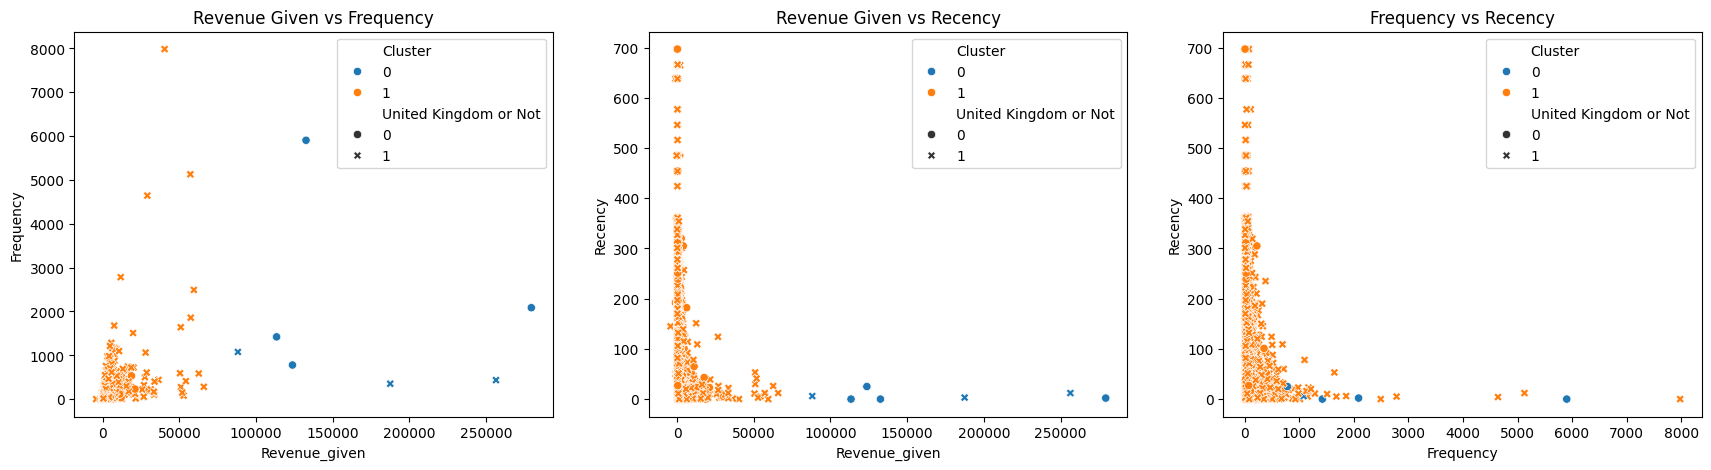

In [34]:
plt.figure(figsize=(21,5))

x_train["Cluster"] = labels

plt.subplot(1,3,1)
sns.scatterplot(data=x_train, x="Revenue_given", y="Frequency", hue="Cluster", style="United Kingdom or Not")
plt.xlabel("Revenue_given")
plt.ylabel("Frequency")
plt.title("Revenue Given vs Frequency")

plt.subplot(1,3,2)
sns.scatterplot(data=x_train, x="Revenue_given", y="Recency", hue="Cluster", style="United Kingdom or Not")
plt.xlabel("Revenue_given")
plt.ylabel("Recency")
plt.title("Revenue Given vs Recency")

plt.subplot(1,3,3)
sns.scatterplot(data=x_train, x="Frequency", y="Recency", hue="Cluster", style="United Kingdom or Not")
plt.xlabel("Frequency")
plt.ylabel("Recency")
plt.title("Frequency vs Recency")

plt.show()

## **Placing Clustering points**

In [50]:
c1_x, c1_y = data[data['Cluster'] == 0].drop(['Cluster'], axis=1).mean()
c2_x, c2_y = data[data['Cluster'] == 1].drop(['Cluster'], axis=1).mean()

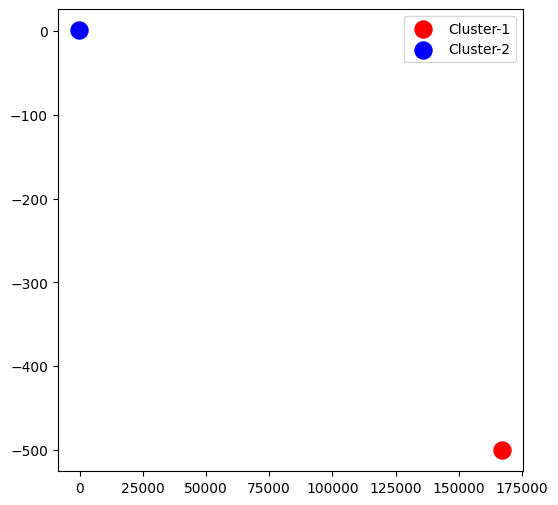

In [66]:
plt.figure(figsize=(6,6))
plt.scatter(c1_x, c1_y, color="red", label="Cluster-1", s = 150)
plt.scatter(c2_x, c2_y, color="blue", label="Cluster-2", s = 150)
plt.legend()
plt.show()